# 11 Data Loading and  Cleaning

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

#  dataset load
df = pd.read_csv("EURUSD.csv")


#Check if NA values are in data
df=df[df['volume']!=0]
df.reset_index(drop=True, inplace=True)
df.isna().sum()
df.tail()


,Gmt time,open,high,low,close,volume
28821,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63
28822,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66
28823,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33
28824,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53
28825,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05


# 22 Feature Engineering

In [3]:
# Calculate ATR, RSI, Moving Averages, and Slopes
def calculate_atr(df, length=20):
    df['high_low'] = df['high'] - df['low']
    df['high_close'] = np.abs(df['high'] - df['close'].shift(1)) #absolute difference between today's high price and yesterday's close price.
    df['low_close'] = np.abs(df['low'] - df['close'].shift(1))
    df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)
    df['atr'] = df['tr'].rolling(window=length).mean()
    return df

def calculate_rsi(df, length=14):     #RSI is a momentum indicator that shows-- the market is overbought or oversold.
    delta = df['close'].diff(1)     #Calculates the day-to-day difference in closing prices (delta) by subtracting the previous day's close from the current day's close.
    gain = (delta.where(delta > 0, 0)).rolling(window=length).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=length).mean()
    rs = gain / loss                  #Calculates the relative strength (RS) as the ratio of the average gains to the average losses.
    df['rsi'] = 100 - (100 / (1 + rs))
    return df

def calculate_moving_averages(df, lengths=[40, 80, 160]):
    for length in lengths:
        df[f'MA{length}'] = df['close'].rolling(window=length).mean()
    return df

def calculate_slope(series):
    slope = np.gradient(series)
    return pd.Series(slope, name=f'{series.name}_slope')

df = calculate_atr(df) #    feature engineering (calculations)
df = calculate_rsi(df)
df = calculate_moving_averages(df, lengths=[40, 80, 160])

df['slope_MA40'] = calculate_slope(df['MA40']) # Add slopes for all (MA40, MA80, MA160, and RSI)
df['slope_MA80'] = calculate_slope(df['MA80'])
df['slope_MA160'] = calculate_slope(df['MA160'])
df['slope_RSI'] = calculate_slope(df['rsi'])

# Clean up temporary columns used for calculations
df.drop(columns=['high_low', 'high_close', 'low_close', 'tr'], inplace=True)

In [4]:
df.tail()

,Gmt time,open,high,low,close,volume,atr,rsi,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_RSI
28821,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63,0.001954,70.710850,1.156618,1.159121,1.167880,0.000153,-0.000109,-0.000134,-0.815568
28822,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66,0.001988,67.108168,1.156768,1.159014,1.167745,0.000117,-0.000120,-0.000138,-4.885812
28823,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33,0.002039,60.939227,1.156853,1.158880,1.167604,0.000088,-0.000120,-0.000139,-3.171176
28824,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53,0.002070,60.765816,1.156944,1.158774,1.167468,0.000106,-0.000101,-0.000134,3.224800
28825,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05,0.001965,67.388826,1.157065,1.158678,1.167336,0.000121,-0.000096,-0.000132,6.623010


# 33 Signal Generation

In [5]:
# Support and Resistance Functions
def support(df, l, n1, n2):  #check if a given level 1 is a support level using n1 and n2 candles before and after the level.
    for i in range(l - n1 + 1, l + 1):
        if df['low'][i] > df['low'][i - 1]:   #iflow is higher than the previous one,
            return 0
    for i in range(l + 1, l + n2 + 1):
        if df['low'][i] < df['low'][i - 1]:   #If a low is lower than the previous one
            return 0
    return 1

def resistance(df, l, n1, n2):
    for i in range(l - n1 + 1, l + 1):
        if df['high'][i] < df['high'][i - 1]:
            return 0
    for i in range(l + 1, l + n2 + 1):
        if df['high'][i] > df['high'][i - 1]:
            return 0
    return 1

# Engulfing \ Star Pattern with Identification
def isEngulfing(row, open_, close_):
    bodydiffmin = 0.002
    bodydiff = abs(open_[row] - close_[row])
    prev_bodydiff = abs(open_[row - 1] - close_[row - 1])
    
    if bodydiff < 0.000001:
        bodydiff = 0.000001

    if bodydiff > bodydiffmin and prev_bodydiff > bodydiffmin and open_[row - 1] < close_[row - 1] and open_[row] > close_[row]:
        return 1  # ---Bearish Engulfing
    elif bodydiff > bodydiffmin and prev_bodydiff > bodydiffmin and open_[row - 1] > close_[row - 1] and open_[row] < close_[row]:
        return 2  # ----Bullish Engulfing
    return 0

def isStar(l, open_, close_, high, low):
    bodydiffmin = 0.0020
    bodydiff = abs(open_[l] - close_[l])
    highdiff = high[l] - max(open_[l], close_[l])
    lowdiff = min(open_[l], close_[l]) - low[l]
    
    if bodydiff < 0.000001:
        bodydiff = 0.000001
    
    ratio1 = highdiff / bodydiff
    ratio2 = lowdiff / bodydiff
    
    if ratio1 > 1 and lowdiff < 0.2 * highdiff and bodydiff > bodydiffmin:
        return 1  # ---Bearish Star
    elif ratio2 > 1 and highdiff < 0.2 * lowdiff and bodydiff > bodydiffmin:
        return 2  # ---Bullish Star
    return 0

# Signal Generation Logic
def generate_signals(df, n1=2, n2=2, backCandles=30, lim=150e-5):
    signal = [0] * len(df)
    open_ = df['open']
    close_ = df['close']
    high = df['high']
    low = df['low']
    
    for row in range(backCandles, len(df) - n2):
        ss = []   #support
        rr = []   #resistence
        for subrow in range(row - backCandles + n1, row + 1):
            if support(df, subrow, n1, n2):
                ss.append(low[subrow])
            if resistance(df, subrow, n1, n2):
                rr.append(high[subrow])

        # Signal Generation based on Engulfing and Star patterns
        engulfing_pattern = isEngulfing(row, open_, close_)
        star_pattern = isStar(row, open_, close_, high, low)
        
        if ((engulfing_pattern == 1 or star_pattern == 1) and closeResistance(row, rr, lim)):
            signal[row] = 1  # --Sell Signal
        elif ((engulfing_pattern == 2 or star_pattern == 2) and closeSupport(row, ss, lim)):
            signal[row] = 2  # --Buy Signal
        else:
            signal[row] = 0  #-- No Signal
    
    df['signal'] = signal
    return df

def closeResistance(l, levels, lim):
    if len(levels) == 0:
        return 0
    return (abs(df['high'][l] - min(levels, key=lambda x: abs(x - df['high'][l]))) <= lim)

def closeSupport(l, levels, lim):
    if len(levels) == 0:
        return 0
    return (abs(df['low'][l] - min(levels, key=lambda x: abs(x - df['low'][l]))) <= lim)

# Generate Signals
df = generate_signals(df)

In [6]:
df.tail()

,Gmt time,open,high,low,close,volume,atr,rsi,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_RSI,signal
28821,15.10.2021 01:00:00.000,1.15940,1.16120,1.15938,1.16082,5738.63,0.001954,70.710850,1.156618,1.159121,1.167880,0.000153,-0.000109,-0.000134,-0.815568,0
28822,15.10.2021 05:00:00.000,1.16082,1.16189,1.15995,1.16034,13149.66,0.001988,67.108168,1.156768,1.159014,1.167745,0.000117,-0.000120,-0.000138,-4.885812,0
28823,15.10.2021 09:00:00.000,1.16033,1.16124,1.15892,1.15923,14914.33,0.002039,60.939227,1.156853,1.158880,1.167604,0.000088,-0.000120,-0.000139,-3.171176,0
28824,15.10.2021 13:00:00.000,1.15923,1.16103,1.15893,1.15953,20002.53,0.002070,60.765816,1.156944,1.158774,1.167468,0.000106,-0.000101,-0.000134,3.224800,0
28825,15.10.2021 17:00:00.000,1.15952,1.16060,1.15933,1.16040,5620.05,0.001965,67.388826,1.157065,1.158678,1.167336,0.000121,-0.000096,-0.000132,6.623010,0


# 44 Target Definition

In [7]:
# Define Target Flexible Logic
pipdiff = 250 * 1e-4  # For TP
SLTPRatio = 1  # pipdiff/Ratio gives SL
#pipdiff = 500 * 1e-5  # for TP (Take Profit)
#SLTPRatio = 2  # pipdiff / Ratio gives SL (Stop Loss)

def mytarget(barsupfront, df, pipdiff=250e-4, SLTPRatio=1):
    length = len(df)
    high = list(df['high'])
    low = list(df['low'])
    close = list(df['close'])
    open = list(df['open'])
    
    trendcat = [None] * length  #  store all the trend classification
    
    for line in range(length - barsupfront - 2):
        valueOpenLow = 0
        valueOpenHigh = 0
        
        for i in range(1, barsupfront + 2):
            value1 = open[line + 1] - low[line + i]   # potential in down trend
            value2 = open[line + 1] - high[line + i]   # potential up tren
            
            valueOpenLow = max(value1, valueOpenLow)  
            valueOpenHigh = min(value2, valueOpenHigh)  

            if (valueOpenLow >= pipdiff and -valueOpenHigh <= (pipdiff / SLTPRatio)):
                trendcat[line] = 1  # --Downtrend
                break
            elif (valueOpenLow <= (pipdiff / SLTPRatio) and -valueOpenHigh >= pipdiff):
                trendcat[line] = 2  # --Uptrend
                break
            else:
                trendcat[line] = 0  # --No trend
    
    return trendcat

# Create 'Target' column using mytarget function
df['mytarget'] = mytarget(barsupfront=10, df=df)

# Drop rows with NaN values in the 'Target' column
df = df.dropna(subset=['mytarget'])

In [8]:
df['mytarget'] = mytarget(16, df)
df.head()

,Gmt time,open,high,low,close,volume,atr,rsi,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_RSI,signal,mytarget
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12166,1.12274,95533.0976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1,05.05.2003 01:00:00.000,1.12242,1.12276,1.12067,1.12126,93778.5996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
2,05.05.2003 05:00:00.000,1.12139,1.12255,1.12030,1.12113,90924.6992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
3,05.05.2003 09:00:00.000,1.12092,1.12331,1.12049,1.12174,91254.6992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
4,05.05.2003 13:00:00.000,1.12194,1.12900,1.12130,1.12712,308003.4083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


# 55 Class Balancing

In [9]:
# Separate majority and minority classes
df_majority = df[df['mytarget'] == 0]
df_minority_down = df[df['mytarget'] == 1]
df_minority_up = df[df['mytarget'] == 2]

# Oversample minority classes
df_minority_down_oversampled = resample(df_minority_down, 
                                        replace=True,     
                                        n_samples=len(df_majority),    
                                        random_state=42)

df_minority_up_oversampled = resample(df_minority_up, 
                                      replace=True,     
                                      n_samples=len(df_majority),    
                                      random_state=42)

# Combine majority class with oversampled minority classes
df_model = pd.concat([df_majority, df_minority_down_oversampled, df_minority_up_oversampled])

# Shuffle the dataset helps avoid bias in model training.
df_model = df_model.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
df.tail()

,Gmt time,open,high,low,close,volume,atr,rsi,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_RSI,signal,mytarget
28809,13.10.2021 01:00:00.000,1.15415,1.15559,1.15409,1.15527,4160.40,0.001775,38.146341,1.156751,1.161030,1.169864,-1.783750e-04,-0.000235,-0.000196,1.174136,0,NaN
28810,13.10.2021 05:00:00.000,1.15528,1.15604,1.15457,1.15565,11030.24,0.001811,41.210375,1.156594,1.160793,1.169667,-1.761250e-04,-0.000240,-0.000201,-0.485649,0,NaN
28811,13.10.2021 09:00:00.000,1.15564,1.15669,1.15363,1.15430,18650.34,0.001906,37.175043,1.156398,1.160550,1.169462,-1.397500e-04,-0.000220,-0.000197,5.747993,0,NaN
28812,13.10.2021 13:00:00.000,1.15430,1.15788,1.15405,1.15780,23598.19,0.002022,52.706360,1.156315,1.160352,1.169273,-4.125000e-05,-0.000168,-0.000182,11.826491,0,NaN
28813,13.10.2021 17:00:00.000,1.15781,1.15975,1.15780,1.15956,11188.68,0.001956,60.828025,1.156316,1.160213,1.169098,1.000000e-06,-0.000143,-0.000174,4.270639,0,NaN


C:\Users\Ali\AppData\Local\Temp\ipykernel_9276\226031025.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax=ax)


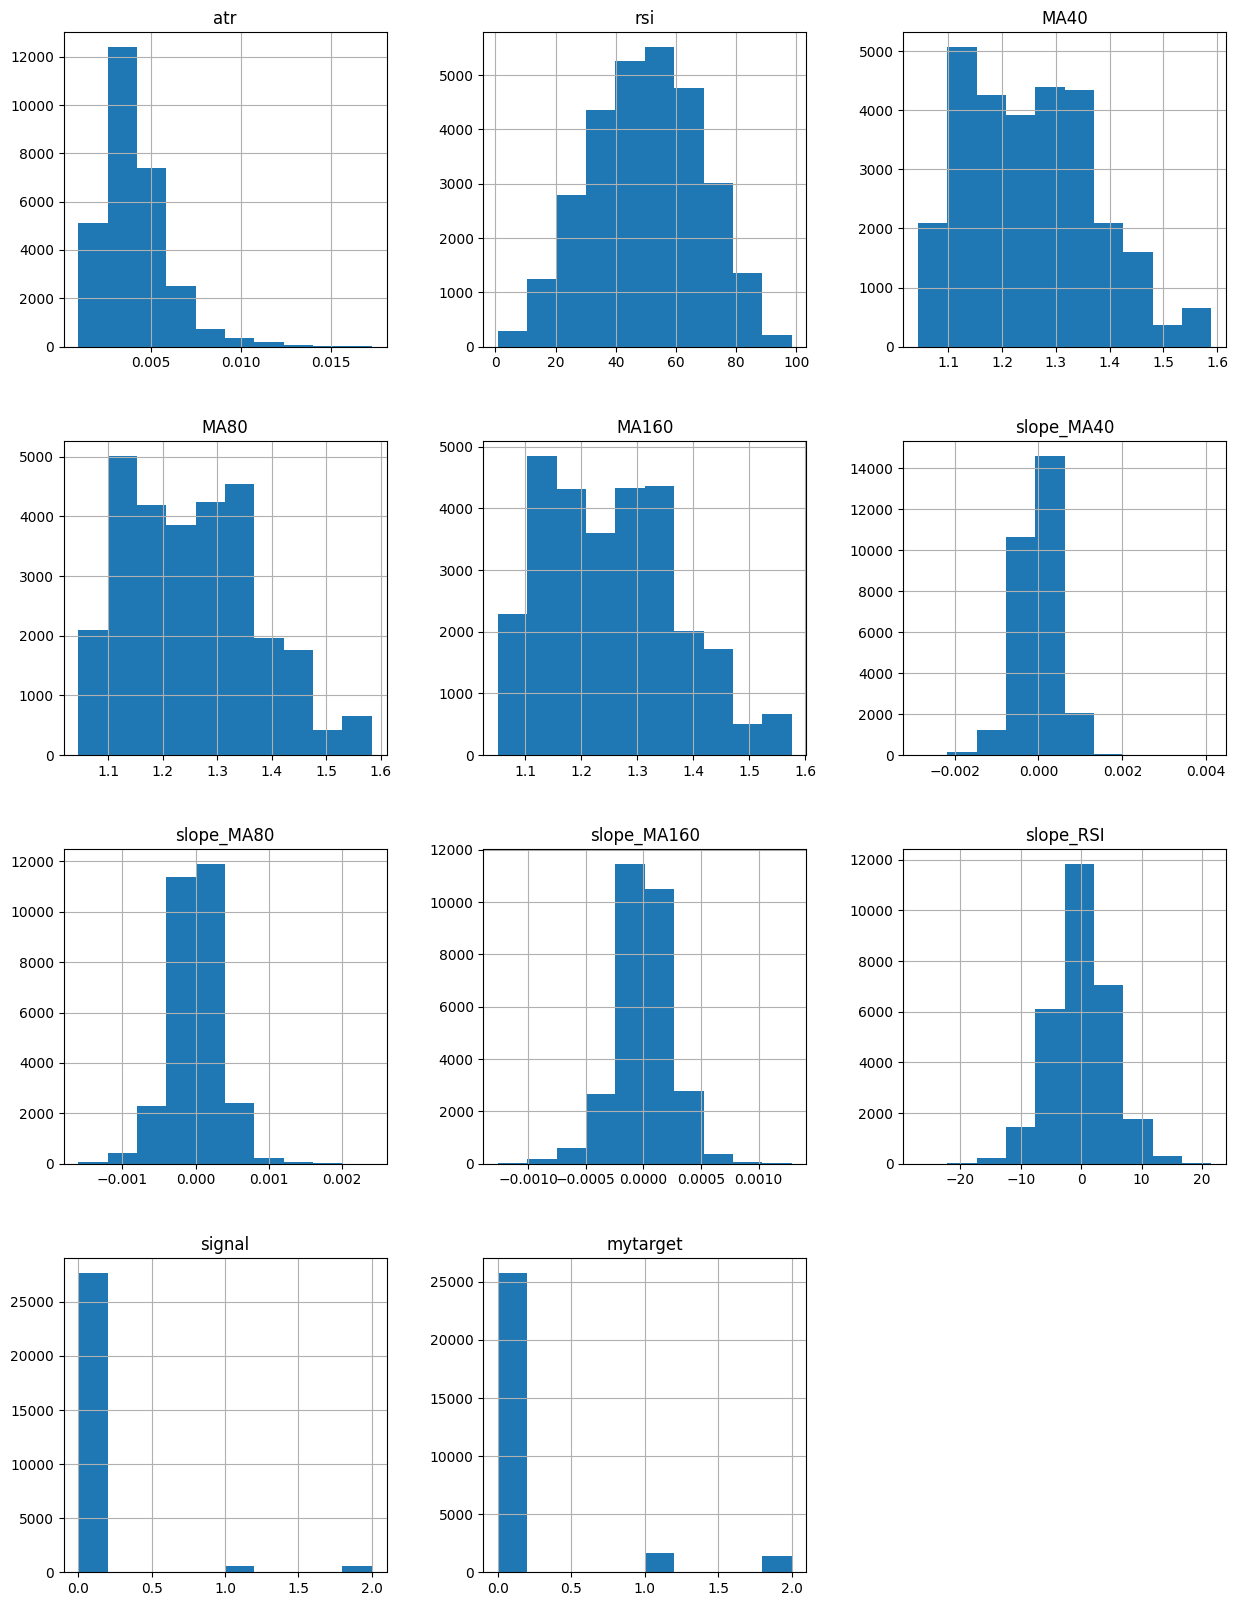

,Gmt time,open,high,low,close,volume,atr,rsi,MA40,MA80,MA160,slope_MA40,slope_MA80,slope_MA160,slope_RSI,signal,mytarget
28809,13.10.2021 01:00:00.000,1.15415,1.15559,1.15409,1.15527,4160.40,0.001775,38.146341,1.156751,1.161030,1.169864,-1.783750e-04,-0.000235,-0.000196,1.174136,0,NaN
28810,13.10.2021 05:00:00.000,1.15528,1.15604,1.15457,1.15565,11030.24,0.001811,41.210375,1.156594,1.160793,1.169667,-1.761250e-04,-0.000240,-0.000201,-0.485649,0,NaN
28811,13.10.2021 09:00:00.000,1.15564,1.15669,1.15363,1.15430,18650.34,0.001906,37.175043,1.156398,1.160550,1.169462,-1.397500e-04,-0.000220,-0.000197,5.747993,0,NaN
28812,13.10.2021 13:00:00.000,1.15430,1.15788,1.15405,1.15780,23598.19,0.002022,52.706360,1.156315,1.160352,1.169273,-4.125000e-05,-0.000168,-0.000182,11.826491,0,NaN
28813,13.10.2021 17:00:00.000,1.15781,1.15975,1.15780,1.15956,11188.68,0.001956,60.828025,1.156316,1.160213,1.169098,1.000000e-06,-0.000143,-0.000174,4.270639,0,NaN


In [11]:
import matplotlib.pyplot as plt

# Plot histograms
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
df_model = df[['atr',	'rsi',	'MA40',	'MA80',	'MA160',	'slope_MA40',	'slope_MA80',	'slope_MA160',	'slope_RSI',	'signal',	'mytarget']]
df_model.hist(ax=ax)
plt.show()
df.tail()

In [12]:
df_model=df_model.dropna()

# 66 Model Training 

In [13]:
# --- prepare attribute for the model
attributes = ['signal', 'atr', 'rsi', 'MA40', 'MA80', 'MA160', 'slope_MA40', 'slope_MA80', 'slope_MA160', 'slope_RSI']

# Ensure these attributes exist in the dataframe
X = df_model[attributes]
y = df_model['mytarget']

# Split data into (train) and (test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Hyperparameter tuning forxgbost model
param_grid = {
    'n_estimators': [50, 100, 200],   # Number of trees in the XGBoost model.
    'max_depth': [3, 6, 9],    # Maximum depth of each tree (how complex the trees can be).
    'learning_rate': [0.01, 0.1, 0.3]  # Controls how fast the model adjusts with each step during training.
}

# Cross-validation and GridSearch
xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predictions and accuracy
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)


print(f"Best Parameters: {grid_search.best_params_}")
print(f"Train Accuracy: {acc_train:.4%}")
print(f"Test Accuracy: {acc_test:.4%}")
print("\nClassification Report for Train:\n")
print(classification_report(y_train, y_pred_train))

print("\nClassification Report for Test:\n")
print(classification_report(y_test, y_pred_test))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 200}
Train Accuracy: 100.0000%
Test Accuracy: 94.8551%

Classification Report for Train:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17925
         1.0       1.00      1.00      1.00      1148
         2.0       1.00      1.00      1.00       972

    accuracy                           1.00     20045
   macro avg       1.00      1.00      1.00     20045
weighted avg       1.00      1.00      1.00     20045


Classification Report for Test:

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      7699
         1.0       0.86      0.60      0.71       501
         2.0       0.83      0.58      0.68       391

    accuracy                           0.95      8591
   macro avg       0.88      0.72      0.79      8591
weighted avg       0.95      0.95  

In [28]:
attributes = ['signal', 'atr', 'rsi', 'MA40', 'MA80', 'MA160', 'slope_MA40', 'slope_MA80', 'slope_MA160', 'slope_RSI']


# Ensure these attributes exist in the dataframe
X = df_model[attributes]
y = df_model['mytarget']

# Train/test split
train_pct_index = int(0.7 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

# XGBoost model training
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Calculate accuracy
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

# Calculate total trades, total wins, and total losses
total_trades = len(pred_test)
total_wins = ((pred_test == 1) & (y_test == 1)).sum()  # Correctly predicted wins
total_losses = ((pred_test == 0) & (y_test == 0)).sum()  # Correctly predicted losses

print('Train Results')
print("Accuracy: {:.4%}".format(acc_train))
print('Test Results')
print("Accuracy: {:.4%}".format(acc_test))


print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

Train Results
Accuracy: 98.7877%
Test Results
Accuracy: 94.7736%
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87     17192
         1.0       0.08      0.06      0.07      1568
         2.0       0.06      0.04      0.05      1285

    accuracy                           0.77     20045
   macro avg       0.33      0.33      0.33     20045
weighted avg       0.75      0.77      0.76     20045

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95      8432
         1.0       0.01      0.05      0.02        81
         2.0       0.00      0.00      0.00        78

    accuracy                           0.91      8591
   macro avg       0.33      0.33      0.32      8591
weighted avg       0.96      0.91      0.94      8591



# 77 Feature Importance Visualization

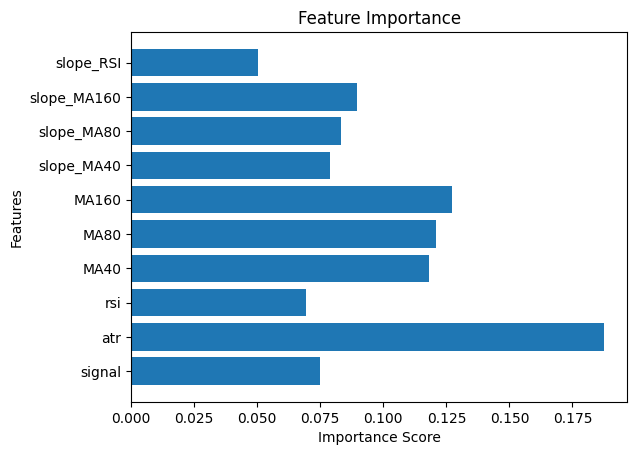

In [14]:
# Feature ploting 
importance = best_model.feature_importances_
plt.barh(attributes, importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [15]:
# Calculate win/loss for the training set
train_wins = (y_train == y_pred_train).sum()  
train_losses = len(y_train) - train_wins  

# Calculate win/loss for the test set
test_wins = (y_test == y_pred_test).sum()  
test_losses = len(y_test) - test_wins 

# Total trades, wins, and losses
total_trades = len(y_train) + len(y_test)
total_wins = train_wins + test_wins
total_losses = total_trades - total_wins

# Output the results
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {total_wins}")
print(f"Losing Trades: {total_losses}")

Total Trades: 28636
Winning Trades: 28194
Losing Trades: 442


In [16]:
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy

import pandas as pd
from backtesting import Strategy, Backtest

# rename columns
df.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
}, inplace=True)

# Define the signal function
def SIGNAL():
    return df['signal']

# Strategy class for backtesting
class MyCandlesStrat(Strategy):  
    def init(self):
        super().init()
        # Load the buy/sell signal from the dataframe
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        # Check if there's already an open position
        if self.signal1 == 2:  # Buy signal
            # Close any posision open for short positions
            if self.position.is_short:
                self.position.close()
            # ---new long position open (buy)
            self.buy()
        
        elif self.signal1 == 1:  # Sell signal
            # Close any position open l for ong positions
            if self.position.is_long:
                self.position.close()
            # ---new short position open (sell)
            self.sell()

# Running the backtest on your dataframe
bt = Backtest(df[['Open', 'High', 'Low', 'Close']], MyCandlesStrat, cash=10_000, commission=.00)
stats = bt.run()

# Print backtest stats
print(stats)

# Plotting the strategy performance
bt.plot()

C:\Users\Ali\AppData\Roaming\Python\Python313\site-packages\backtesting\backtesting.py:1054: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  (data.index.is_numeric() and
C:\Users\Ali\AppData\Local\Temp\ipykernel_9276\2314954982.py:46: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df[['Open', 'High', 'Low', 'Close']], MyCandlesStrat, cash=10_000, commission=.00)


Start                                     0.0
End                                   28813.0
Duration                              28813.0
Exposure Time [%]                   99.764004
Equity Final [$]                  17071.42121
Equity Peak [$]                    20157.4433
Return [%]                          70.714212
Buy & Hold Return [%]                3.279477
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -22.195607
Avg. Drawdown [%]                   -1.259175
Max. Drawdown Duration                 7679.0
Avg. Drawdown Duration             134.806604
# Trades                                704.0
Win Rate [%]                        54.545455
Best Trade [%]                       6.096476
Worst Trade [%]                     -9.651743
Avg. Trade [%]                    

GridPlot(id='p1296', ...)